In [100]:
import numpy as np

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats
import statsmodels.formula.api as smf
import statsmodels.api as sm

In [101]:
# fjerner forklaringsvariabler vi ikke trenger

df_start = pd.read_csv("../resources/lego.population.csv", sep =",", encoding ="latin1")


df2 = df_start[['Set_Name', 'Theme', 'Pieces', 'Price', 'Pages', 'Unique_Pieces', 'Minifigures']]

# fjerner observasjoner med manglende datapunkter
#df2 = df2.dropna()

# gjør themes om til string og fjern alle tegn vi ikke vil ha med
df2['Theme'] = df2['Theme'].astype(str)
df2['Theme'] = df2['Theme'].str.replace(r'[^a-zA-Z0-9\s-]', '', regex = True)

# fjerner dollartegn og trademark-tegn fra datasettet
df2['Price'] = df2['Price'].str.replace('\$', '', regex = True)

# og gjør så prisen om til float
df2['Price'] = df2['Price'].astype(float)

#egen rens
df2['Gender'] = "Neutral"


boy_names = []

with open("../resources/boy_names.txt") as file:
  for index, line in enumerate(file):
    if index < 6:
      continue
    name = line.strip().lower()

    boy_names.append(name)

girl_names = []

with open("../resources/girl_names.txt") as file:
  for index, line in enumerate(file):
    if index < 6:
      continue
    name = line.strip().lower()

    girl_names.append(name)


def inGirlList(set_name):
  for girl in girl_names:
    if str(set_name).find(girl) != -1:
      return "Girl"
  return "Neutral"

def inBoyList(set_name):
  for boy in boy_names:
    if str(set_name).find(boy) != -1:
      return "Boy"
  return "Neutral"

# Apply the functions to create the 'Gender' column
df2['Gender'] = df2['Set_Name'].apply(lambda x: inGirlList(x) if inGirlList(x) == 1 else inBoyList(x))

themes = dict()


for line in open("../resources/theme_gender.txt"):
  if line.startswith("*") or line.isspace():
    continue
  else:
    words = line.strip().split("=")
    themes[words[0].lower().replace(" ", "")] = words[1].replace(" ", "")

print(themes.keys())


for index, lego_set in df_start.iterrows():
  set_theme = str(lego_set["Theme"]).lower().replace(" ", "")
  if set_theme in themes.keys():
    newValue = int((themes[set_theme]))



    if newValue == 1:
      df2['Gender'][index] = "Boy"
    elif newValue == 2:
      df2['Gender'][index] = "Girl"
    else:
      df2['Gender'][index] = "Neutral"

df2 = df2.dropna()
df2['Gender'] = df2['Gender'].astype(str)


#579

df2

C:\Users\Admin\AppData\Local\Temp\ipykernel_4248\1268497092.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['Theme'] = df2['Theme'].astype(str)
C:\Users\Admin\AppData\Local\Temp\ipykernel_4248\1268497092.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['Theme'] = df2['Theme'].str.replace(r'[^a-zA-Z0-9\s-]', '', regex = True)
C:\Users\Admin\AppData\Local\Temp\ipykernel_4248\1268497092.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using

dict_keys(['batman', 'dc', 'marvel', 'ninjago', 'speedchampions', 'spider-man', 'technic', 'minecraft', 'overwatch', 'starwars', 'hiddenside', 'monkiekid', 'disney', 'dots', 'friends', 'legofrozen2', 'powerpuffgirls', 'unikitty!', 'trollsworldtour', 'legoart', 'architecture', 'brickheadz', 'city', 'classic', 'creator3-in-1', 'creatorexpert', 'duplo', 'juniors', 'legosupermario', 'minifigures', 'minions', 'xtra', 'ideas', 'thelegomovie2', 'harrypotter', 'jurassicworld', 'legobricksketches', 'legoeducation', 'poweredup', 'strangerthings'])


C:\Users\Admin\AppData\Local\Temp\ipykernel_4248\1268497092.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['Gender'][index] = "Neutral"
C:\Users\Admin\AppData\Local\Temp\ipykernel_4248\1268497092.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['Gender'][index] = "Neutral"
C:\Users\Admin\AppData\Local\Temp\ipykernel_4248\1268497092.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['Gender'][index] = "Neutral"
C

,Set_Name,Theme,Pieces,Price,Pages,Unique_Pieces,Minifigures,Gender
13,Stephanie's Summer Heart Box,Friends,95.0,7.99,40.0,52.0,1.0,Girl
16,Woody & RC,Disney,69.0,9.99,28.0,36.0,1.0,Neutral
17,Mia's Summer Heart Box,Friends,85.0,7.99,36.0,41.0,1.0,Girl
18,Olivia's Summer Heart Box,Friends,93.0,7.99,40.0,48.0,2.0,Girl
19,Police Patrol Car,City,92.0,9.99,36.0,52.0,1.0,Neutral
...,...,...,...,...,...,...,...,...
1171,1989 Batmobile,Batman,3306.0,249.99,404.0,484.0,3.0,Neutral
1172,Tree House,Ideas,3036.0,199.99,428.0,482.0,4.0,Neutral
1173,Welcome to Apocalypseburg!,THE LEGO MOVIE 2,3178.0,299.99,452.0,692.0,13.0,Boy
1174,Jurassic Park: T. rex Rampage,Jurassic World,3120.0,249.99,464.0,525.0,6.0,Boy


In [106]:
#multippel lineær modell
modell_mlr = smf.ols('Price ~ Pieces + Unique_Pieces + Minifigures + Pages + C(Gender, Treatment("Neutral"))', data = df2)
print(modell_mlr.fit().summary())

                            OLS Regression Results                            
Dep. Variable:                  Price   R-squared:                       0.849
Model:                            OLS   Adj. R-squared:                  0.848
Method:                 Least Squares   F-statistic:                     697.2
Date:                Mon, 06 Nov 2023   Prob (F-statistic):          1.14e-301
Time:                        16:41:19   Log-Likelihood:                -3334.8
No. Observations:                 752   AIC:                             6684.
Df Residuals:                     745   BIC:                             6716.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                                              coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------

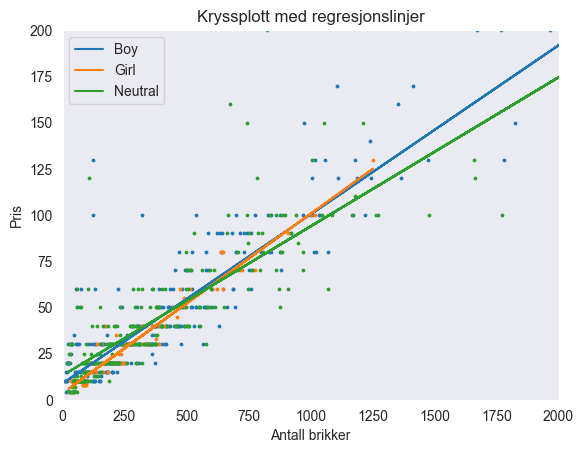

In [103]:
myGenders = ['Boy', 'Girl', 'Neutral']
subset_df = df2[df2['Gender'].isin(myGenders)]

# enkel LR for hvert kjønn hver for seg
resultater = []
for i, gender in enumerate(myGenders):
  sub_model_gender = smf.ols('Price ~ Pieces', data=subset_df[subset_df['Gender'] == gender])
  resultater.append(sub_model_gender.fit())

  # plott av dataene og regresjonslinjene
for i, gender in enumerate(myGenders):
  slope = resultater[i].params['Pieces']
  intercept = resultater[i].params['Intercept']

  regression_x = np.array(subset_df[subset_df['Gender'] == gender]['Pieces'])
  regression_y = slope * regression_x + intercept

  # Plot scatter plot and regression line
  plt.scatter(subset_df[subset_df['Gender'] == gender]['Pieces'], subset_df[subset_df['Gender'] == gender]['Price'], color=plt.cm.tab10(i), s=3)
  plt.plot(regression_x, regression_y, color=plt.cm.tab10(i), label=gender)

plt.xlabel('Antall brikker')
plt.ylabel('Pris')
plt.xlim(0, 2000)
#
#
plt.ylim(0, 200)

plt.title('Kryssplott med regresjonslinjer')
plt.legend()
plt.grid()
plt.show()


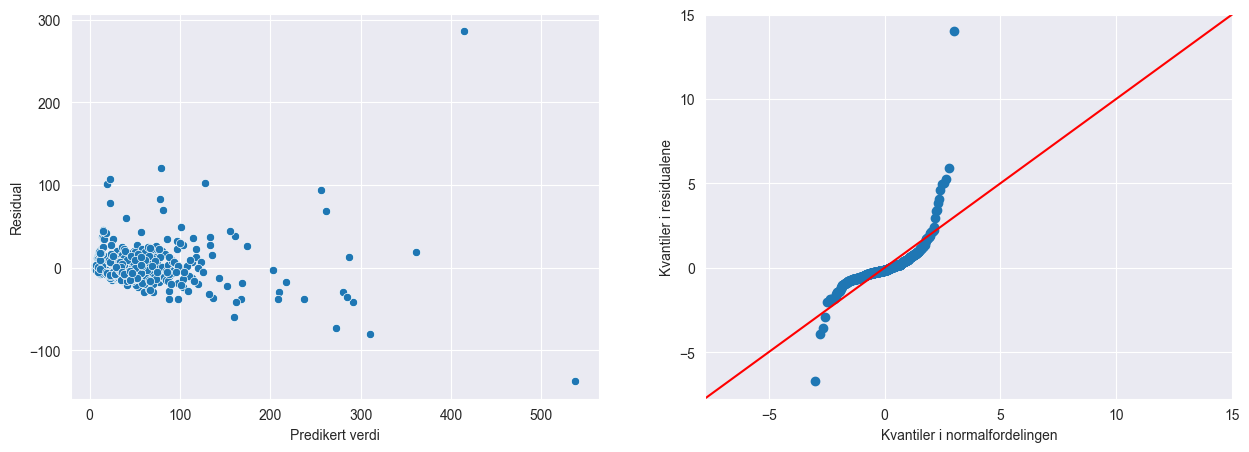

In [104]:
figure, axis = plt.subplots(1, 2, figsize = (15, 5))
sns.scatterplot(x = modell_mlr.fit().fittedvalues, y = modell_mlr.fit().resid, ax = axis[0])
axis[0].set_ylabel("Residual")
axis[0].set_xlabel("Predikert verdi")

# Lage kvantil-kvantil-plott for residualene
sm.qqplot(modell_mlr.fit().resid, line = '45', fit = True, ax = axis[1])
axis[1].set_ylabel("Kvantiler i residualene")
axis[1].set_xlabel("Kvantiler i normalfordelingen")
plt.show()

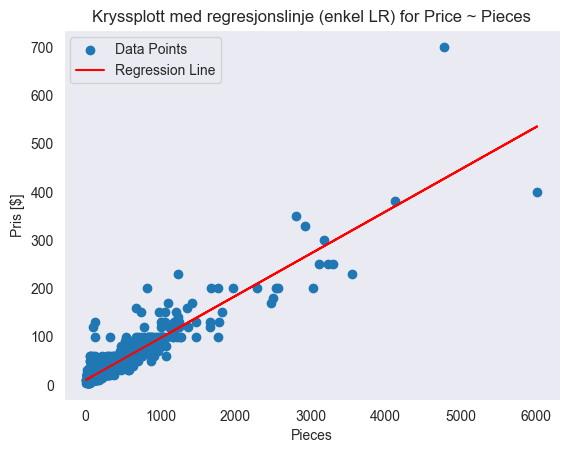

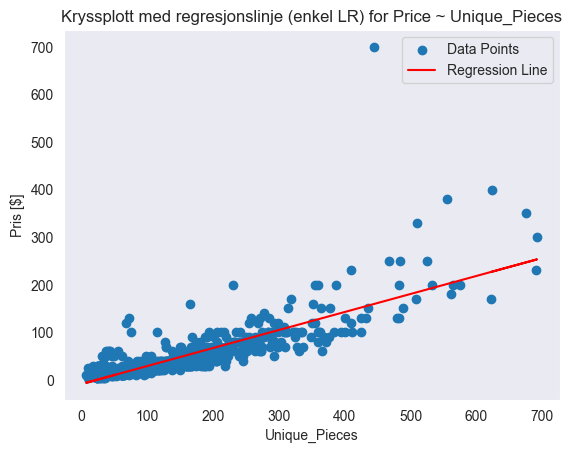

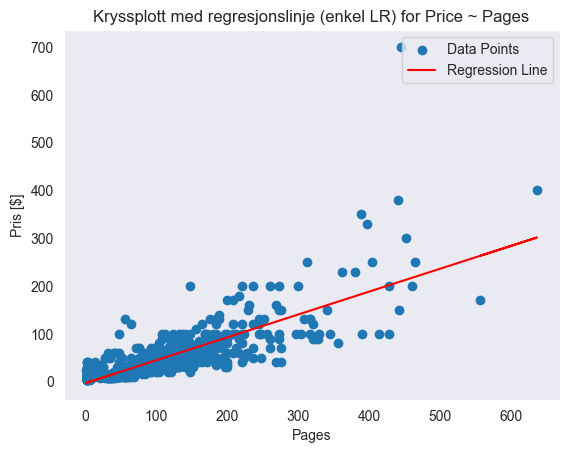

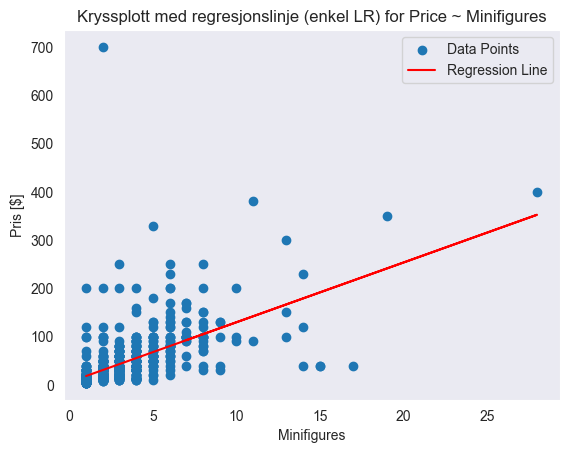

In [105]:
#Enkel lineær regresjon av alle de forskjellige variablene

variables = ['Pieces', 'Unique_Pieces', 'Pages', 'Minifigures']

for i in variables:
  formel = 'Price ~ ' + str(i)

  modell = smf.ols(formel, data = df2)
  resultat = modell.fit()

  resultat.summary()

  slope = resultat.params[i]
  intercept = resultat.params['Intercept']

  regression_x = np.array(df2[i])

  regression_y = slope * regression_x + intercept

  plt.scatter(df2[i], df2['Price'], label='Data Points')
  plt.plot(regression_x, regression_y, color='red', label='Regression Line')
  plt.xlabel(i)
  plt.ylabel('Pris [$]')
  plt.title('Kryssplott med regresjonslinje (enkel LR) for ' + formel)
  plt.legend()
  plt.grid()
  plt.show()